In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# df = pd.read_csv('/content/sales_train.csv',parse_dates=True, index_col='date' )


sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
items_cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [4]:
sales_item = sales_train.merge(items, on='item_id', how='left')
sales_item_shops = sales_item.merge(shops, on='shop_id', how='left')
df = sales_item_shops.merge(items_cats, on='item_category_id', how='left')
df.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
2712476,20.06.2015,29,48,19900,129.0,1.0,ТУРБО,40,"Томск ТРЦ ""Изумрудный Город""",Кино - DVD
2568855,19.04.2015,27,22,3014,1190.0,1.0,Dr.Web Антивирус АВ 2 ПК/1 год (картонная упак...,75,Москва Магазин С21,Программы - Для дома и офиса
284002,16.03.2013,2,18,2308,849.0,1.0,"Call of Duty: Black Ops II [PС, Jewel, русская...",30,"Красноярск ТЦ ""Июнь""",Игры PC - Стандартные издания
138838,17.02.2013,1,52,21668,149.0,1.0,ЧЕРЕПАШКИ НИНДЗЯ: Битва супергероев (Регион),40,"Уфа ТК ""Центральный""",Кино - DVD
1390259,14.02.2014,13,31,8058,500.0,1.0,iTunes 500 руб.,32,"Москва ТЦ ""Семеновский""","Карты оплаты (Кино, Музыка, Игры)"
1577781,29.04.2014,15,25,14713,149.0,1.0,МОЙ МАЛЕНЬКИЙ ПОНИ. Любимые истории Пинки Пай ...,40,"Москва ТРК ""Атриум""",Кино - DVD
905568,16.09.2013,8,25,22121,399.0,1.0,Я ОЧЕНЬ ВОЗБУЖДЕН,40,"Москва ТРК ""Атриум""",Кино - DVD
1633087,03.05.2014,16,25,7006,2999.0,1.0,"Thief [PS4, русская версия]",20,"Москва ТРК ""Атриум""",Игры - PS4
351948,01.04.2013,3,23,2448,599.0,1.0,"Crysis 3. Hunter Edition [PC, русская версия]",28,"Москва ТК ""Буденовский"" (пав.А2)",Игры PC - Дополнительные издания
1087689,21.11.2013,10,19,12321,399.0,1.0,КАДРЫ,40,"Курск ТЦ ""Пушкинский""",Кино - DVD


In [5]:
df_cnt_item = df.groupby('date_block_num').agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'date_block_num':'number_of_month', 'item_cnt_day':'item_cnt'})
fig = px.line(df_cnt_item, x="number_of_month", y="item_cnt")
fig.update_layout(
    title='The number of goods sold on a monthly basis',
    xaxis_title='Time',
    yaxis_title='Sales')
fig.show()

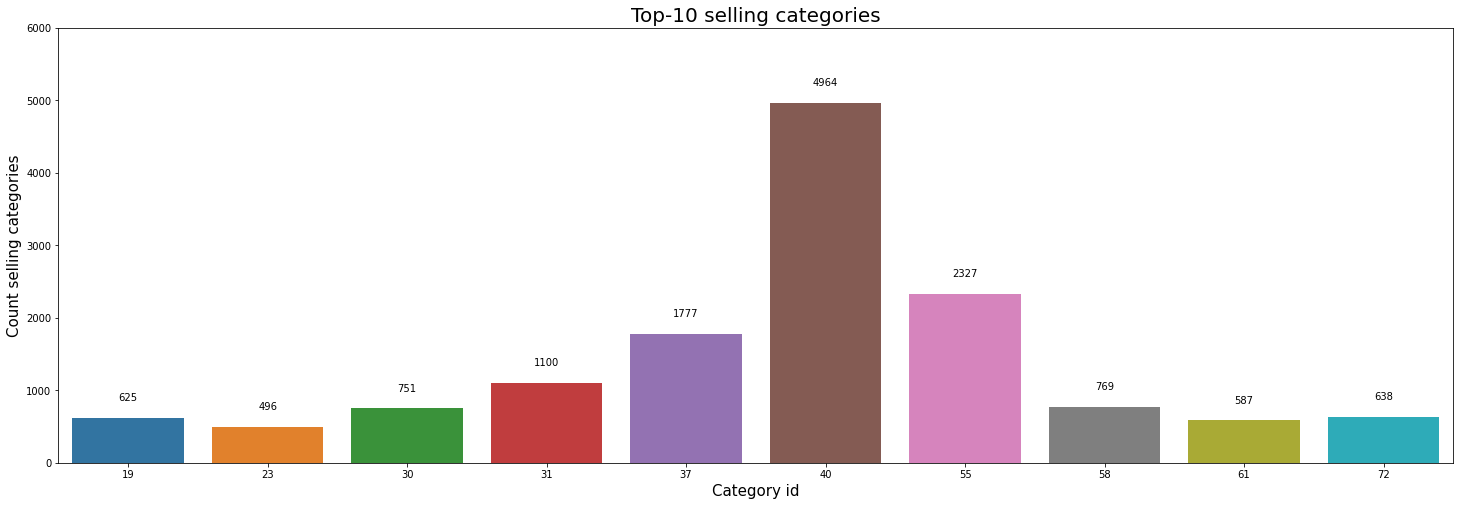

In [6]:
top_categories = df.groupby('item_category_id').agg({'item_id':'nunique'}).reset_index().rename(columns={'item_id':'count_items'}).sort_values(by='count_items', ascending=False).head(10)
plt.figure(figsize=(25,8))
plt.title('Top-10 selling categories', size=20)
ax = sns.barplot(y=top_categories['count_items'], 
                 x=top_categories['item_category_id'])
for p in ax.patches:
        ax.annotate (str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Category id', size=15)
plt.ylabel('Count selling categories', size=15)
plt.ylim(None,6000)
plt.show()

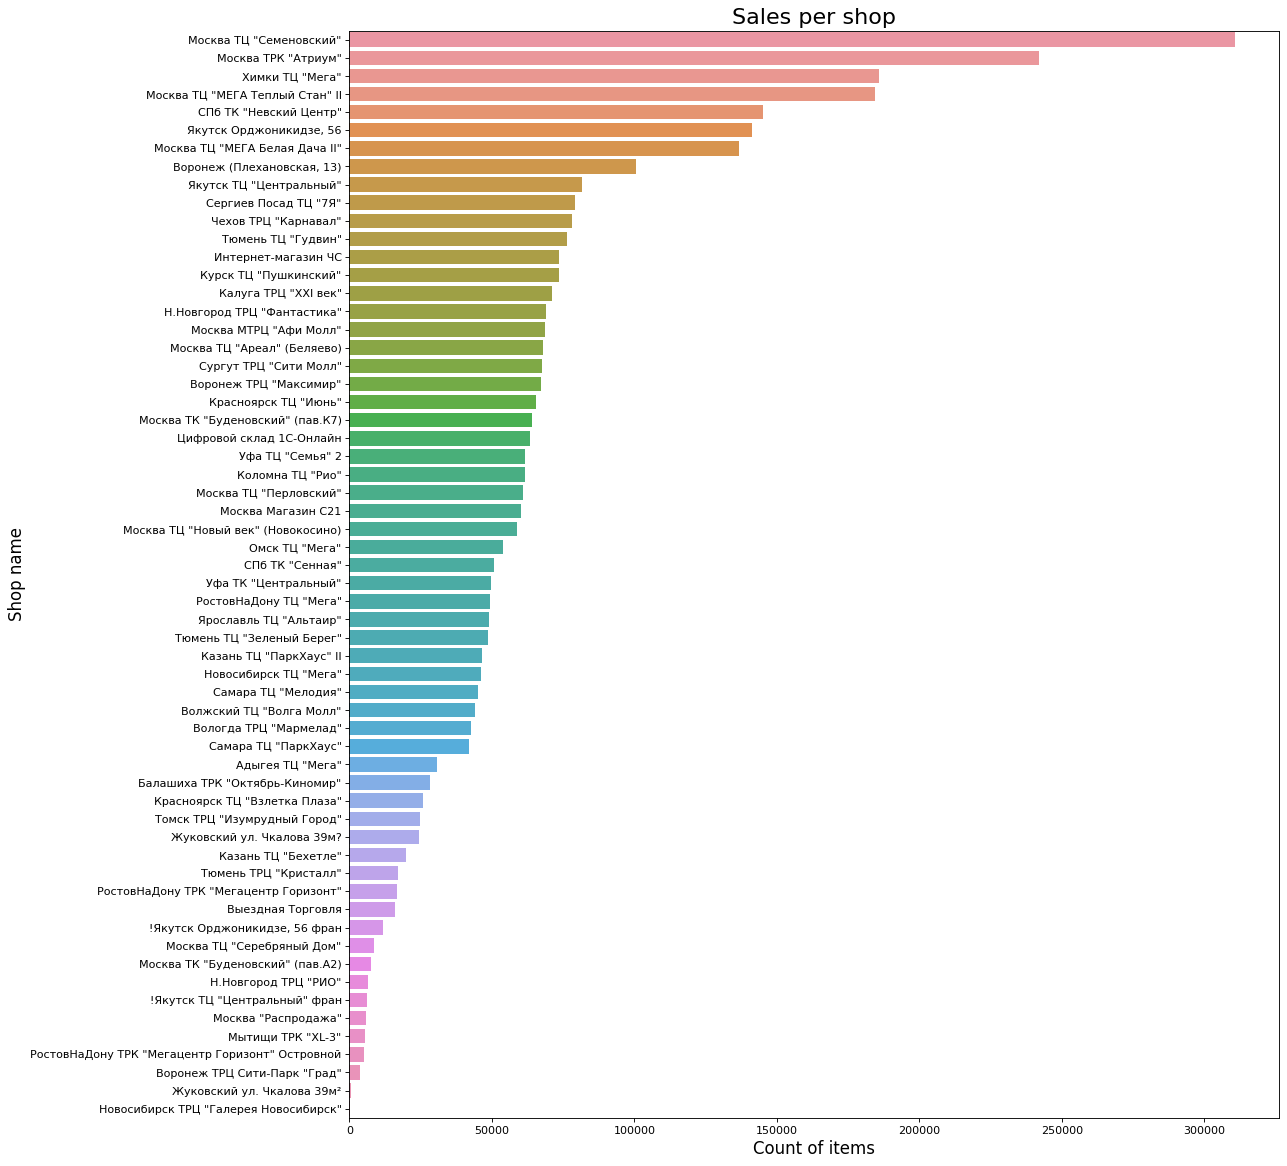

In [7]:
items_per_shop = df.groupby('shop_name').agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_items'}).sort_values(by='total_cnt_items', ascending=False)
plt.figure(figsize=(15,18), dpi=80)
plt.title('Sales per shop', size=20)
ax = sns.barplot(x=items_per_shop['total_cnt_items'], y=items_per_shop['shop_name'])
plt.xlabel('Count of items', size=15)
plt.ylabel('Shop name', size=15)
plt.show()

In [8]:
df = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')

#Here we choose the period we want to analyze
# df=df.loc['01-07-2015':'30-11-2015']
df['date']=pd.to_numeric(df['date'],errors = 'coerce')
orders = len(df)
print(orders)
print(df['date'].dtypes)

2935849
float64


In [9]:
sales_train['date'] = pd.to_datetime(sales_train['date'],format = '%d.%m.%Y')
dataset = sales_train.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')
dataset.reset_index(inplace = True)
dataset = pd.merge(test,dataset,on = ['item_id','shop_id'],how = 'left')

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning:

merging between different levels can give an unintended result (1 levels on the left,2 on the right)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [10]:
# lets fill all NaN values with 0
dataset.fillna(0,inplace = True)

dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)

dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# normalize the dataset
# dataset = df.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [12]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [13]:
# # split into train and test sets
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,LSTM

In [16]:
#Create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=64,input_shape = (33,1)))
model.add(Dense(1))
model.add(Dropout(0.4))
model.compile(loss='mse', optimizer='adam',metrics = ['mean_squared_error'])
model.summary()
model.fit(X_train, y_train, epochs=10, batch_size=4096)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
53/53 [==============================] - 4s 13ms/step - loss: 47.6819 - mean_squared_error: 47.6819
Epoch 2/10
53/53 [==============================] - 1s 12ms/step - loss: 20.8491 - mean_squared_error: 20.8491
Epoch 3/10
53/53 [==============================] - 1s 13ms/step - loss: 59.7179 - mean_squared_error: 59.7179
Epoch 4/10
53/53 [==============================]

In [17]:
# creating submission file 
submission_pfs = model.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('prediction.csv',index = False)

In [18]:
prediction=model.predict(X_test)
train=model.predict(X_train)

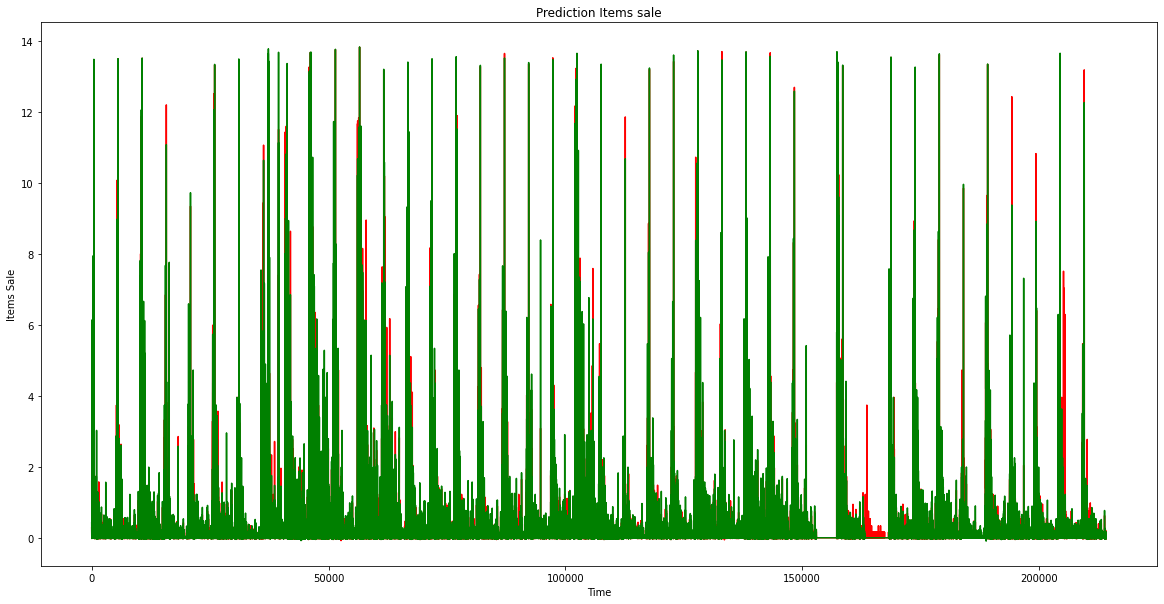

In [19]:
plt.figure(figsize=(20,10))
plt.plot(prediction,color = 'red')
plt.plot(train,color = 'green')
plt.title('Prediction Items sale')
plt.xlabel('Time')
plt.ylabel('Items Sale')
plt.show()